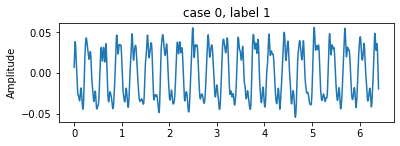

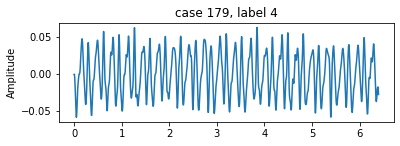

3


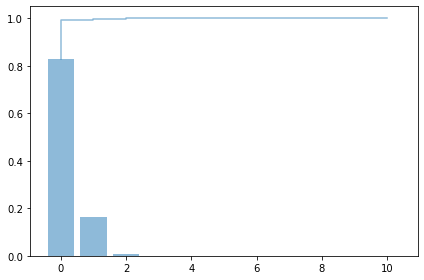

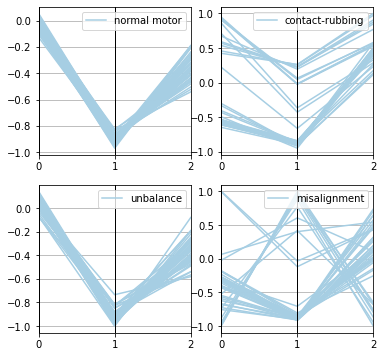

Softmax linear model in X accuracy: 60.555555555555564 %
Degree 3 polynomial svc with C=1 to X accuracy: 58.88888888888889 %
Degree 3 polynomial svc with C=1 to X accuracy: 50.55555555555556 %
kNN with 4 neighbors in X accuracy: 85.0 %
Best hyperparameters for SVM: {'C': 10, 'degree': 3, 'kernel': 'poly'}
SVM with optimized hyperparameters accuracy: 55.55555555555556 %
Best hyperparameters for kNN: {'n_neighbors': 5}
kNN with optimized hyperparameters accuracy: 36.111111111111114 %
Best hyperparameters for Decision Tree: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}
Decision Tree with optimized hyperparameters accuracy: 33.333333333333336 %


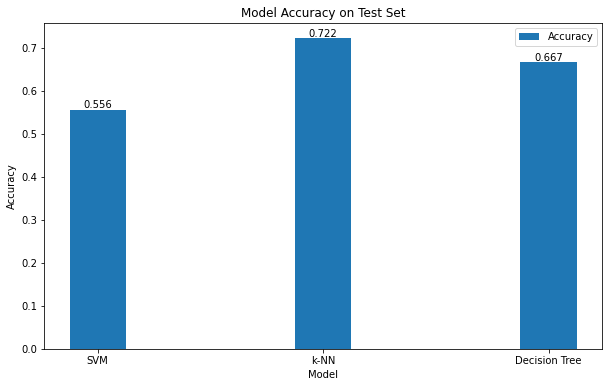

In [3]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

fname = join(os.getcwd(),'data','180data_new_select_denoised.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['Y_wavedeno']

Nc, N = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = np.array([np.ones(45)*1, np.ones(45)*2, np.ones(45)*3, np.ones(45)*4]).reshape(-1)
# 1 = normal rotor, 2 = contact-rubbing, 3 = unbalance, 4 = misalignment.

Ts = 3.125 * 1e-3 # sampling time
time1 = (np.linspace(1,N,N) - 1) * Ts
time2 = (np.linspace(1,Nc,Nc) - 1) * Ts

for case in np.array([0,179]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time1,dataset[case,:])
    plt.ylabel('Amplitude')
    plt.show()
    
    
Data_AR = []
for i in range(180):
    res = AutoReg(dataset[i], lags = 10).fit()
    Data_AR.append(res.params)
Data_AR = np.array(Data_AR)



pca = PCA()
principalComponents = pca.fit_transform(Data_AR)

exp_var_ratio = pca.explained_variance_ratio_
cum_sum_principalvalues = np.cumsum(exp_var_ratio)

plt.bar(range(0, len(exp_var_ratio)), exp_var_ratio, alpha = .5)
plt.step(range(0, len(cum_sum_principalvalues)), cum_sum_principalvalues, alpha = .5)
plt.tight_layout()
plt.show

for i in range(len(cum_sum_principalvalues)):
    if cum_sum_principalvalues[i] > .9999:
        print(i)
        n_c = i
        break

pca = PCA(n_components = n_c)
X = pca.fit_transform(Data_AR)
X.shape

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

target = []
for item in y:
    if item == 1:
        target.append('normal motor')
    if item == 2:
        target.append('contact-rubbing')
    if item == 3:
        target.append('unbalance')
    if item == 4:
        target.append('misalignment')

X2red = pd.concat([pd.DataFrame(scaler.fit_transform(X)), pd.DataFrame({'target': target})], axis =1)

X2red.describe()


plt.figure(figsize=(6,6))
plt.subplot(221)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 'normal motor'], 'target', colormap = plt.get_cmap('Paired'))
plt.subplot(222)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 'contact-rubbing'], 'target', colormap = plt.get_cmap('Paired'))
plt.subplot(223)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 'unbalance'], 'target', colormap = plt.get_cmap('Paired'))
plt.subplot(224)
pd.plotting.parallel_coordinates(X2red[X2red['target'] == 'misalignment'], 'target', colormap = plt.get_cmap('Paired'))
plt.show()

Xscaled = scaler.fit_transform(X)
softmax_reg1 = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=.09)
y1 = softmax_reg1.fit(Xscaled, y)
y1_pred = np.int32(y1.predict(Xscaled))



def accuracy(model, y_pred):
    error_count = 0
    for i in range(len(y_pred)):
        if (y_pred[i] != y[i]):
            error_count += 1

    accuracy_score = 1 - (error_count / len(y_pred))
    print(model, 'accuracy:', str(100 * accuracy_score), '%')


    
accuracy('Softmax linear model in X', y1_pred)

svc_p = svm.SVC(C=1, kernel='poly', degree = 4, random_state=0)
svc_s = svm.SVC(C=.01, kernel='sigmoid', random_state=0)
knn_4 = knn(n_neighbors = 4, n_jobs = -1)

clf_p = svc_p.fit(X, y)
yh_p = clf_p.predict(X)
accuracy('Degree 3 polynomial svc with C=1 to X', yh_p)
clf_s = svc_s.fit(X, y)
yh_s = clf_s.predict(X)
accuracy('Degree 3 polynomial svc with C=1 to X', yh_s)
clf_knn = knn_4.fit(X, y)
yh_knn = clf_knn.predict(X)
accuracy('kNN with 4 neighbors in X', yh_knn)


from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# Hyperparameter tuning for SVM

param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['poly', 'sigmoid'], 'degree': [3, 4, 5]}
grid_search_svm = GridSearchCV(svm.SVC(random_state=0), param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)

# Display the best hyperparameters for SVM
print("Best hyperparameters for SVM:", grid_search_svm.best_params_)

# Use the SVM model with the best hyperparameters
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
accuracy('SVM with optimized hyperparameters', y_pred_svm)




# Hyperparameter tuning for kNN

param_grid_knn = {'n_neighbors': [3, 4, 5, 6]}
grid_search_knn = GridSearchCV(knn(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)

# Display the best hyperparameters for kNN
print("Best hyperparameters for kNN:", grid_search_knn.best_params_)

# Use the kNN model with the best hyperparameters
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
accuracy('kNN with optimized hyperparameters', y_pred_knn)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Hyperparameter tuning for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=0), param_distributions=param_dist_dt, n_iter=100, cv=5)
random_search_dt.fit(X_train, y_train)

# Display the best hyperparameters for Decision Tree
print("Best hyperparameters for Decision Tree:", random_search_dt.best_params_)

# Use the Decision Tree model with the best hyperparameters
best_dt = random_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
accuracy('Decision Tree with optimized hyperparameters', y_pred_dt)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

accuracy_score_svm = accuracy_score(y_test, y_pred_svm)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)   
accuracy_score_dt = accuracy_score(y_test, y_pred_dt)

# Models, hyperparameters, and accuracies
models = ['SVM', 'k-NN', 'Decision Tree']
hyperparameters = [
    {'C': 1, 'kernel': 'poly', 'degree': 4},
    {'n_neighbors': 4},
    {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
]
accuracies = [accuracy_score_svm, accuracy_score_knn, accuracy_score_dt]

# Create a DataFrame
summary_df = pd.DataFrame({
    'Model': models,
    'Hyperparameters': hyperparameters,
    'Test Set Accuracy': accuracies
})





# Plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
bar_positions = np.arange(len(models))

# Plot accuracies
bars = ax.bar(bar_positions, accuracies, bar_width, label='Accuracy')

# Add labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(models)
ax.legend()

# Add numerical values on top of bars
for bar, acc in zip(bars, accuracies):
    yval = acc
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Title and labels
plt.title('Model Accuracy on Test Set')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
